# Libraries

In [317]:
import rasterio

import pandas as pd

import numpy as np

import os
#from os import path

from pathlib import Path
from pandas import DataFrame

import matplotlib.pyplot as plt

from osgeo import gdal, gdalconst
from os import path


# Global 

In [351]:
os.getcwd()
os.chdir('/home/pierre-louis/forest_mind/analysis')

In [352]:
IMAGES_DATA_PATH = "/mnt/uksa-storage/guatemala/"
ref_year = 2017
years = list(range(2018,2021))


# Helpers

# Deforestation CSVs
## Import deforestation data

In [328]:
## Import deforestation CSVs
# list of time variant raster names
pathlist = list(Path("intermediate").glob('*_ds.tif'))
df_file_paths = list(map(lambda y: f"intermediate/deforestation_{y}_ds.csv", years)) 
dist_df_file_paths = list(map(lambda y: f"intermediate/distance_to_deforestation_in_year_{y}_ds.csv", years)) 
print(df_file_paths)
#print(dist_df_file_paths)


['intermediate/deforestation_2018_ds.csv', 'intermediate/deforestation_2019_ds.csv', 'intermediate/deforestation_2020_ds.csv']


In [331]:
defor_2018 = pd.read_csv(df_file_paths[0])
(defor_2018!=0).count()

0    3785719
dtype: int64

In [332]:
df = []

for f in df_file_paths:
    df.append(pd.read_csv(f, skiprows = 1, header=None))
    #print("Length: " + str(len(df[0])))
    #print("NAs: " + str(df[0].isnull().count()))
    #print("Zeros: " + str((df[0]==0).sum(axis =0)))

df


[         0
 0        0
 1        0
 2        0
 3        0
 4        0
 ...     ..
 3785714  0
 3785715  0
 3785716  0
 3785717  0
 3785718  0
 
 [3785719 rows x 1 columns],          0
 0        0
 1        0
 2        0
 3        0
 4        0
 ...     ..
 3785714  0
 3785715  0
 3785716  0
 3785717  0
 3785718  0
 
 [3785719 rows x 1 columns],          0
 0        0
 1        0
 2        0
 3        0
 4        0
 ...     ..
 3785714  0
 3785715  0
 3785716  0
 3785717  0
 3785718  0
 
 [3785719 rows x 1 columns]]

In [333]:
defor = pd.DataFrame(df)
defor

ValueError: Must pass 2-d input. shape=(3, 3785719, 1)

In [334]:
a,b = np.unique(df, return_counts = True)
print(a)
print(b)


[0 1]
[11321892    35265]


# Raster

### Helpers

In [384]:
# LABELS
# let's see what the class labels correspond to
with open('GSI_LandNow_LCC_Delivery_2_ColourMap.clr') as f:
    lines = f.readlines()
    
labels = {}
for l in lines:
    labels.update({int(l.split(' ')[0]):l.split(' ')[-2]})
labels.update({11:'coffee'})
labels.update({-9999:'outside AOI'})


def read_lu(filename, year, labels):
    """Read LU and return class counts in dataframe"""
    rst = rasterio.open(filename)
    data = rst.read(1)
    a, b = np.unique(data, return_counts=True)
    df = pd.DataFrame(index =a)
    df['lu'] = df.index.map(labels)
    df['counts']=b
    df['year']=year
    return rst, data, df


def read_defor(filename, year, labels_defor):
    """Read deforestation and return class counts in dataframe"""
    labels_defor = {0:"Forest", 1:"Deforestation"}
    rst = rasterio.open(filename)
    data = rst.read(1)
    a, b = np.unique(data, return_counts=True)
    df = pd.DataFrame(index =a)
    df['lu'] = labels_defor
    df['counts']=b
    df['year']=year
    return rst, data, df

def template(source, target, resolution):
    """ Create template file at imposed resolution in meters"""
    os.system(f"rm {target}")
    cmd = f"gdalwarp -co BIGTIFF=YES -co COMPRESS=LZW -tr {resolution} {resolution} {source} {target}"
    os.system(cmd)
    return

def reproject_raster_to_match_template(input_file, output_file, projection_method = None, data_type = None, referencefile = "/home/pierre-louis/forest_mind/analysis/template.tif"):
    if(path.isfile(output_file)):
        return

    inpt = gdal.Open(input_file, gdalconst.GA_ReadOnly)
    inputProj = inpt.GetProjection()
    inputTrans = inpt.GetGeoTransform()

    reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    if data_type == None: 
        data_type = bandreference.DataType

    if projection_method == None:
        projection_method = gdalconst.GRA_Bilinear

    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(output_file,x,y,1,data_type, options = [ 'COMPRESS=LZW' ] )
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)

    gdal.ReprojectImage(inpt,output,inputProj,referenceProj,projection_method)

    del output

## Deforestation

### Import deforestation raster

In [354]:
os.chdir('/home/pierre-louis/forest_mind/analysis')
df_rst_paths = list(map(lambda y: f"intermediate/deforestation_{y}_ds.tif", years)) 
print(df_rst_paths)

['intermediate/deforestation_2018_ds.tif', 'intermediate/deforestation_2019_ds.tif', 'intermediate/deforestation_2020_ds.tif']


In [355]:
## Import 2018 deforestation raster
rst_2018, dt_2018, df_2018 = read_defor(f"intermediate/deforestation_2018_ds_resol.tif", 2018, labels_defor)


In [356]:
df_2018

,lu,counts,year
0.0,0,3755523,2018
1.0,1,30197,2018


In [357]:
a,b = np.unique(dt_2018, return_counts = True) 
print(a)
print(b)

[0. 1.]
[3755523   30197]


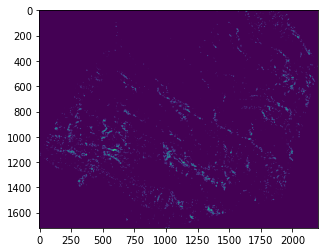

In [358]:
plt.imshow(dt_2018)

## Land use


In [385]:
os.getcwd()

'/mnt/uksa-storage/land_cover'

In [388]:
os.chdir('/mnt/uksa-storage/land_cover')

lu_file_path = '/mnt/uksa-storage/land_cover/2017/Smoothed/GSI_LandNow_LCC_2017_Iteration_2_Smoothed'

In [389]:
rst_lu, dt_lu, df_lu = read_lu(lu_file_path+'.tif', 2017, labels)


In [395]:
dt_lu[0][1]
#dt_lu[dt_lu[]]
dt_lu == 10

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [397]:
df_lu

,lu,counts,year
-9999,outside AOI,4427012,2017
1,Shrubs,267958,2017
2,Vegetation,153020,2017
3,Cropland,1569697,2017
4,Urban,220044,2017
5,vegetation,273611,2017
7,body,11511,2017
10,Forest,5813304,2017
11,coffee,3135186,2017


In [431]:
#number of pixels with forest
int(df_lu.counts[df_lu['lu']=='Forest'])

5813304

In [435]:
bin_lu = dt_lu
bin_lu = np.where(dt_lu!=10, 0, 1)
a, b = np.unique(bin_lu, return_counts=True)
print(a)
print(b)
#check that transformation to binary gives the same number of forest and non-forest pixels 
print(int(df_lu.counts[df_lu['lu']=='Forest'])==b[1])
print(int(df_lu.counts[df_lu['lu']=='Forest'])!=b[0])


[0 1]
[10058039  5813304]
True
True


In [436]:
bin_rst_lu = rst_lu
bin_rst_lu = np.where(rst_lu!=10, 0, 1)
a, b = np.unique(bin_rst_lu, return_counts=True)
print(a)
print(b)
#check that transformation to binary gives the same number of forest and non-forest pixels 
print(int(rst_lu.counts[df_lu['lu']=='Forest'])==b[1])
print(int(rst_lu.counts[df_lu['lu']=='Forest'])!=b[0])

[0]
[1]


AttributeError: 'DatasetReader' object has no attribute 'counts'

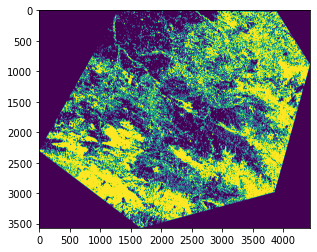

In [444]:
plt.imshow(bin_lu)

In [441]:
msk = rst_lu.read_masks(1)
msk.shape

(3569, 4447)

(3569, 4447)

### Reproject land use to template

In [370]:
# 
reproject_raster_to_match_template(lu_file_path+'.tif', 
                             f'/home/pierre-louis/forest_mind/analysis/intermediate/land_use_2017.tif', 
                             None,
                             None,
                             #f'/home/pierre-louis/forest_mind/analysis/intermediate/template.tif'
                             f"intermediate/deforestation_2018_ds_resol.tif"
                             )

In [371]:
# change resolution
source = f'/home/pierre-louis/forest_mind/analysis/intermediate/land_use_2017.tif'
target = f'/home/pierre-louis/forest_mind/analysis/intermediate/land_use_2017_resol.tif'
resolution = 20
template(source, target, resolution)

### Import land use raster

In [372]:
## Import 2017 land use raster
rst_lu, dt_lu, df_lu = read_lu(f'/home/pierre-louis/forest_mind/analysis/intermediate/land_use_2017_resol.tif', 2017, labels)


In [373]:
rst_lu.profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 2201, 'height': 1720, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(20.0, 0.0, 603558.1124792217,
       0.0, -20.0, 1742194.128229793), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

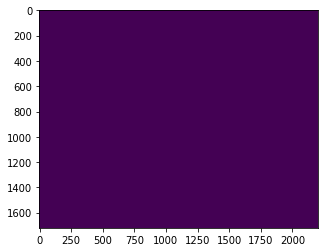

In [374]:
plt.imshow(dt_lu)

In [349]:
df_lu

,lu,counts,year
0,NaN,3785720,2017


## Compare deforestation to land use

In [377]:
# confirm that the profile is the same
rst_lu.profile


{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 2201, 'height': 1720, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(20.0, 0.0, 603558.1124792217,
       0.0, -20.0, 1742194.128229793), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [378]:
rst_2018.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2201, 'height': 1720, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(20.0, 0.0, 603558.1124792217,
       0.0, -20.0, 1742194.128229793), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [261]:
# confirm the size is the same
df_lu['counts'].sum()-df_2018['counts'].sum()

0

In [269]:
# check that deforestation in 2018 was forest in 2017
df_2018[df_2018['lu']==1]==df_lu[df_lu['lu']=='Forest']

/home/ubuntu/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


ValueError: Can only compare identically-labeled DataFrame objects